In [1]:
import matplotlib.pyplot as plt
from mmrely import *
import numpy as np
import pickle
import os
import glob
import pandas as pd
from scipy.interpolate import interp1d, PchipInterpolator, Akima1DInterpolator


plt.rcParams['font.family'] = 'Times New Roman'

def awgn(signal, snr_db):
    if snr_db is None:
        return signal
    else:
        signal_power = np.mean(signal**2)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear
        noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
        noisy_signal = signal + noise  
        noisy_signal = np.clip(noisy_signal, a_min=1e-10, a_max=None)  
        return noisy_signal

def db(rcs_data):
    return 10 * np.log10(rcs_data)

def save_pickle(obj, filename):
    try:
        with open(filename, 'wb') as file:
            pickle.dump(obj, file)
    except Exception as e:
        raise e

def load_pickle(filename):
    try:
        with open(filename, 'rb') as file:
            obj = pickle.load(file)
        return obj
    except Exception as e:
        print(f"Error occurred while loading pickle file: {e}")
        raise e

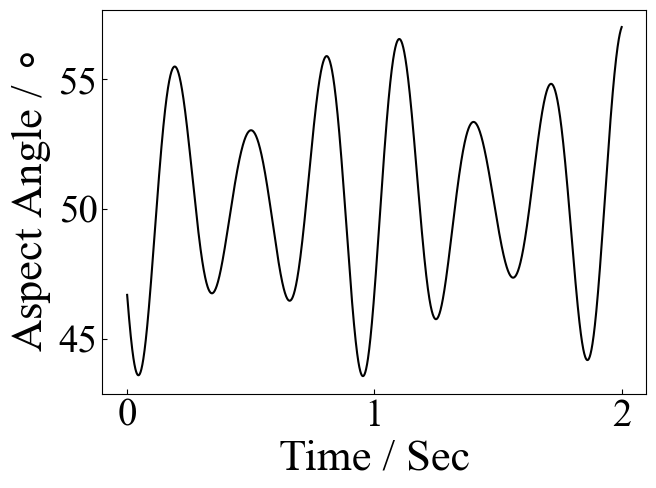

In [2]:
# plt.figure(figsize=(12,3))

a = pickle.load(open('los_list_0.pkl', 'rb'))
# plt.plot(a[0]['LOS'])
los = a[0]['LOS']
x = np.linspace(0,2,2048)
plt.plot(x,los, color='black')

ax = plt.gca()
ax.set_xticks([0, 1, 2])

fontsize = 32

ax.set_xlabel('Time / Sec', fontsize=fontsize)
ax.set_ylabel(r'Aspect Angle / $\circ$', fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=28)
ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed


plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

plt.savefig("./LOS.png", dpi=500, bbox_inches='tight')

In [8]:
# dt = 1 / 1024
# R = [np.linalg.norm(i) for i in a[0]['Radar_warhead']]
# x = np.arange(len(R)) * dt  # 生成 x 轴数据

# # 计算首尾相连的直线参数
# k = (R[-1] - R[0]) / (x[-1] - x[0])  # 计算斜率 k
# b = R[0] - k * x[0]  # 计算截距 b

# # 计算用于绘制直线的两个端点
# x_line = [x[0], x[-1]]
# y_line = [R[0], R[-1]]  # 其实直接用 R[0] 和 R[-1] 作为端点值

# plt.figure(figsize=(12, 3))
# plt.plot(x, R, color='black', label="Distance Curve")
# # plt.plot(x_line, y_line, linestyle="dashed", color="red", linewidth=2, label="Connecting Line")  # 绘制首尾连接直线

# ax = plt.gca()
# ax.set_xticks([0, 1, 2])

# fontsize = 25

# ax.set_xlabel('Time (s)', fontsize=fontsize)
# ax.set_ylabel(r'Distance (m)', fontsize=fontsize)

# plt.tick_params(axis='both', which='major', labelsize=25)
# ax.get_yaxis().get_offset_text().set_size(25)  # 调整刻度字体大小

# plt.tick_params(direction='in')

# plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

# # plt.legend()  # 添加图例
# plt.savefig("./Distance.png", dpi=500, bbox_inches='tight')
# plt.show()


In [9]:
# v_r = np.diff(R) / dt
# v_r = np.append(v_r, v_r[-1])

# plt.figure(figsize=(12,3))
# plt.plot(x, v_r, color='black')

# ax = plt.gca()
# ax.set_xticks([0, 1, 2])

# fontsize = 25

# ax.set_xlabel('Time ', fontsize=fontsize)
# ax.set_ylabel(r'Velocity (s)', fontsize=fontsize)

# plt.tick_params(axis='both', which='major', labelsize=25)
# ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed


# plt.tick_params(direction='in')

# plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

# plt.savefig("./Velocity.png", dpi=500, bbox_inches='tight')


In [10]:
CF_n = 10e9
target = 0

h_csv = f"../../StaticData/{target}/H_{CF_n}Hz.csv" 
v_csv = f"../../StaticData/{target}/V_{CF_n}Hz.csv" 
h_data = pd.read_csv(v_csv)
h_data.head(5)

,Frequency,Polarisation,Theta,Phi,Re(Etheta),Im(Etheta),Re(Ephi),Im(Ephi),RCS(Theta),RCS(Phi),RCS(Total)
0,1.000000e+10,0.0,29.00,0.0,0.010852,0.052669,-1.148834e-05,0.000205,0.036340,5.305494e-07,0.036341
1,1.000000e+10,0.0,29.01,0.0,0.013232,0.051556,6.110710e-07,0.000213,0.035601,5.705029e-07,0.035602
2,1.000000e+10,0.0,29.02,0.0,0.015643,0.050310,-4.736939e-05,0.000173,0.034882,4.063407e-07,0.034882
3,1.000000e+10,0.0,29.03,0.0,0.017911,0.049008,-1.241065e-05,0.000185,0.034213,4.316298e-07,0.034213
4,1.000000e+10,0.0,29.04,0.0,0.020150,0.047524,-5.861806e-05,0.000174,0.033483,4.237672e-07,0.033484


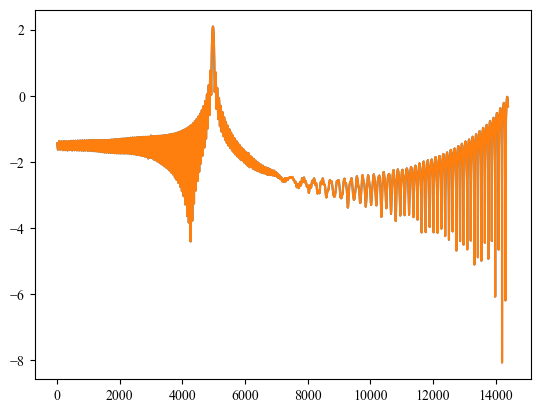

In [11]:
plt.plot(np.log10(4*np.pi*np.abs(h_data["Re(Etheta)"].values + 1j * h_data["Im(Etheta)"].values)**2))
plt.plot(np.log10(h_data["RCS(Theta)"]))

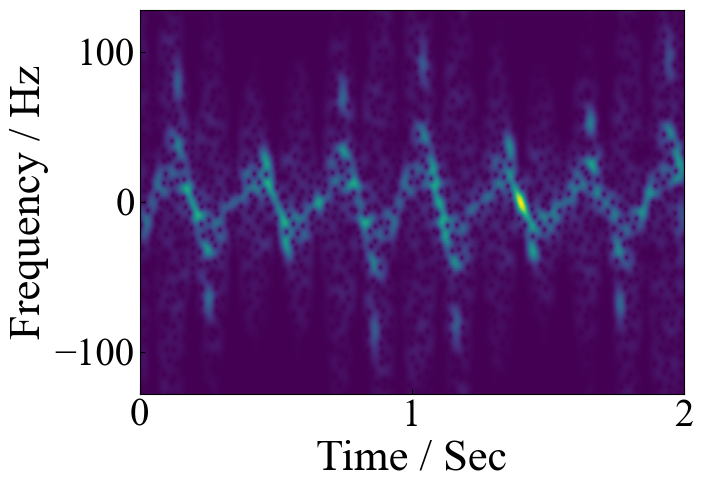

In [43]:
class Echo:
    def __init__(self, target_idx, los_angles):
        self.target_idx = target_idx
        self.los_angles = los_angles
        self.electric_field_data, self.theta = self.extract_electric_field_data(CF_n = 11e9)

    def read_csv(self, file_path):
        return pd.read_csv(file_path)
    
    def extract_electric_field_data(self, CF_n):
        h_csv = f"../../StaticData/{self.target_idx}/H_{CF_n}Hz.csv" 
        v_csv = f"../../StaticData/{self.target_idx}/V_{CF_n}Hz.csv" 

        h_data = self.read_csv(h_csv)
        v_data = self.read_csv(v_csv)

        Etheta_H = h_data["Re(Etheta)"].values + 1j * h_data["Im(Etheta)"].values
        Ephi_H = h_data["Re(Ephi)"].values + 1j * h_data["Im(Ephi)"].values

        Etheta_V = v_data["Re(Etheta)"].values + 1j * v_data["Im(Etheta)"].values
        Ephi_V = v_data["Re(Ephi)"].values + 1j * v_data["Im(Ephi)"].values   

        electric_field_data = {
            "HH": Ephi_H,
            "HV": Etheta_H,
            "VV": Etheta_V,
            "VH": Ephi_V,
        }  

        theta_values = h_data["Theta"].values
        return electric_field_data, theta_values
    
    def compute_echo(self, electric_field_data):
        cs_real = {}
        cs_imag = {}

        for key, field in electric_field_data.items():
            # Use the best interp
            cs_real[key] = interp1d(self.theta, np.real(field.T), kind='cubic')
            cs_imag[key] = interp1d(self.theta, np.imag(field.T), kind='cubic')

        echoes = {}
        rcses = {}
        for key in electric_field_data.keys():
            ys_real = cs_real[key](self.los_angles)
            ys_imag = cs_imag[key](self.los_angles)
            echoes[key] = ys_real + 1j * ys_imag
            rcses[key] = 4*np.pi*np.abs(echoes[key])**2
        return echoes, rcses
             
    def get_echo(self):
        echoe = self.compute_echo(self.electric_field_data)
        return echoe
    
target_idx = 0
echo = Echo(target_idx, los)
echo_values, rcs_values = echo.get_echo()


def STFT(st):
    winlen = 64
    _, _, Zxx = stft(st, fs=256, window = windows.hamming(winlen),nperseg=winlen, nfft=256, noverlap=winlen-1,boundary='zeros',return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)

t = np.linspace(0, 2, 2048)
c = 3e8
dt = t[1] - t[0]

fc = 10e9

# # 计算径向速度 v_r
# v_r = np.diff(R) / dt
# v_r = np.append(v_r, v_r[-1])  # 补齐数组长度

# # 计算多普勒频移 f_d
# lambda_ = c / fc
# f_d = 2 * v_r / lambda_

# s_baseband = echo_values['VV'] * np.exp(-1j * 2 * np.pi * f_d * t)
pol = 'HV'
s_baseband = echo_values[pol] 

tf = STFT(s_baseband)
plt.imshow(np.abs(tf), aspect='auto', extent=[0, 2, -128, 128]) 

# # 获取当前坐标轴
ax = plt.gca()

# # 设置y轴的位置
# ax.set_yticks([-50,0,50])
ax.set_xticks([0, 1, 2])

fontsize = 32

ax.set_xlabel('Time / Sec',fontsize=fontsize)
ax.set_ylabel('Frequency / Hz',fontsize=fontsize)

plt.tick_params(axis='both', which='major', labelsize=28)
# ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed


plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

plt.savefig(f"./{pol}.png", dpi=500, bbox_inches='tight')

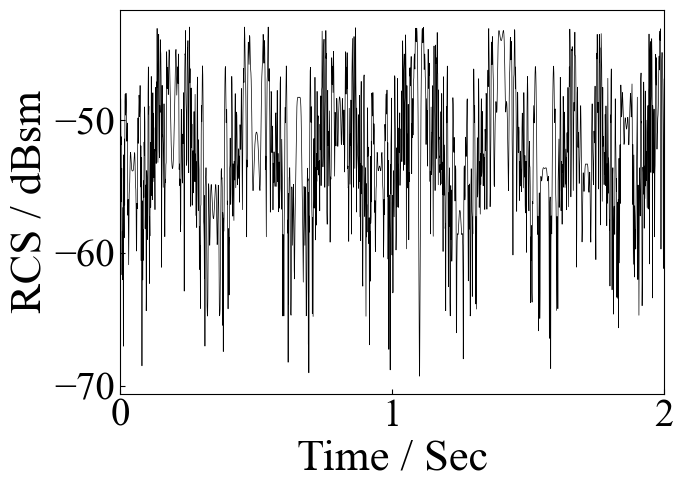

In [46]:
plt.plot(np.linspace(0,2,2048), 10*np.log10(np.abs(s_baseband)**2*4*np.pi), color='black', linewidth=0.5)
# # 获取当前坐标轴
ax = plt.gca()

# # 设置y轴的位置
# ax.set_yticks([-50,0,50])
ax.set_xticks([0, 1, 2])
ax.set_position([0.15, 0.15, 0.7, 0.7]) 
fontsize = 32

ax.set_xlabel('Time / Sec',fontsize=fontsize)
ax.set_ylabel('RCS / dBsm',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=28)
# ax.get_yaxis().get_offset_text().set_size(25)  # Adjust the size as needed
ax.set_xlim([0, 2])
# ax.set_yticks([-60, -55, -50])
 
plt.tick_params(direction='in')

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15)

plt.savefig(f"./RCS_{pol}.png", dpi=500, bbox_inches='tight')

6300


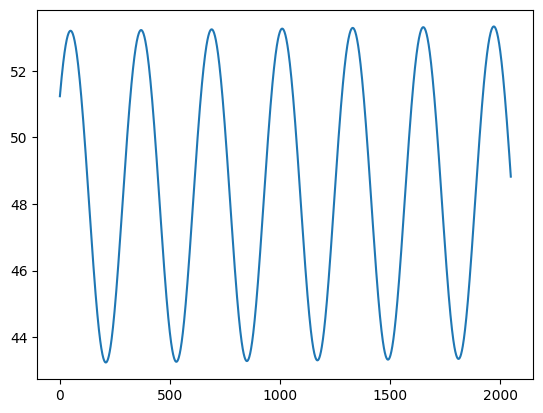

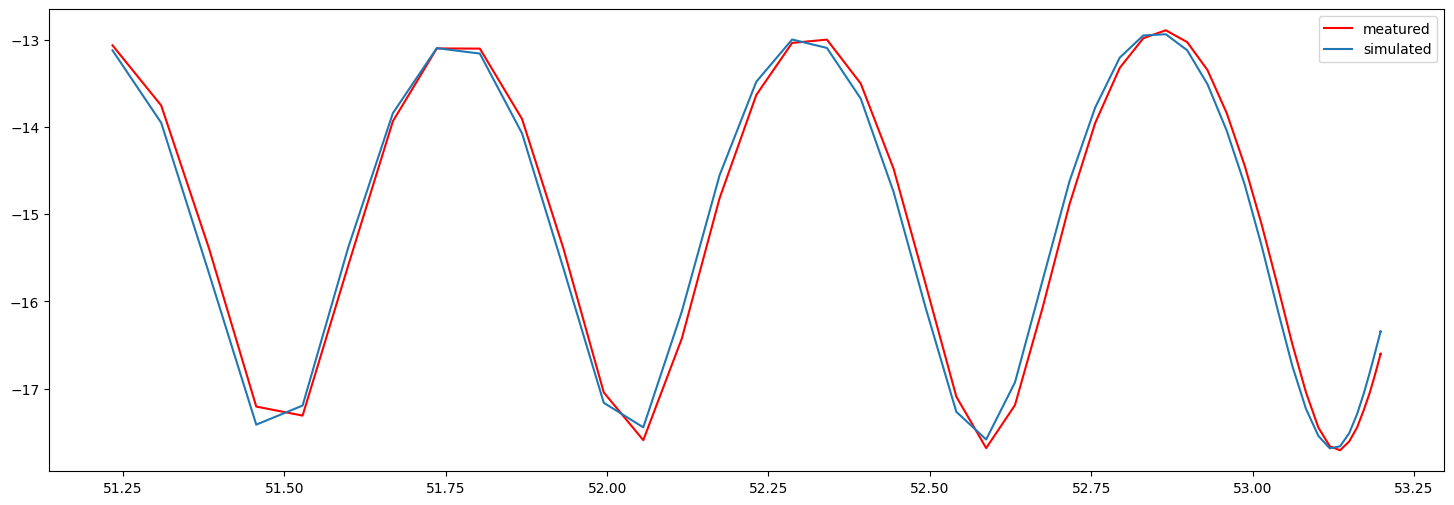

In [6]:
los_dir_list = glob.glob(r'../../mD_Dataset/Los_data/*')

los_list = load_pickle(los_dir_list[1]) 

los = los_list[1]['LOS']
print(len(los_list))
plt.plot(los);

# Example usage
target_idx = 0
echo = Echo(target_idx, los)
echo_values, rcs_values = echo.get_echo()

nfft = 512
def STFT(st,nfft):
    winlen = 64
    _, _, Zxx = stft(st, fs=1024, window = windows.hamming(winlen), nperseg=winlen, nfft=nfft ,noverlap=winlen-1, boundary='zeros', return_onesided=False)
    return np.fft.fftshift(Zxx,axes=0)

pol = 'VV'
echo =  echo_values[pol]
rcs = rcs_values[pol]

Z = STFT(echo,nfft)
T =2 
t = np.linspace(0,T,2048)
nfft = np.linspace(0,nfft,nfft)

meatured = pd.read_csv('./50_11Ghz.csv')

# plt.imshow(np.abs(Z)[:,:-1],origin='lower',vmin=0, vmax=1e-2)
# plt.pcolormesh(t, nfft, np.abs(Z)[:,:-1])
plt.figure(figsize=(18,6))
plt.plot(meatured['Theta'], 10*np.log10(meatured['RCS(Theta)']), 'r-', label = 'meatured')
plt.plot(los[:50], 10*np.log10(rcs)[:50], label = 'simulated')
plt.legend()

In [7]:
# cost 31min except 
for los_pkl in los_dir_list:
    if 'test' in los_pkl:
        base_dir = 'test/'
    else:
        base_dir = 'train/'

    with open(los_pkl, 'rb') as file:
        los_list = pickle.load(file)
        
    for i,item in enumerate(los_list):
        data_dic = {}
        Data_dir = './' + base_dir + str(item['Target_ID'])+ '/'
        os.makedirs(Data_dir, exist_ok= True)
        # inherate
        data_dic['target_id'] = item['Target_ID']
        data_dic['los'] = item['LOS'][:512]
        data_dic['orbit_id'] = item['Orbit_ID']
        data_dic['radar_id'] = item['Radar_ID']
        # EM data
        echo_extractor = Echo(item['Target_ID'], item['LOS'][:512])

        data_dic['echo'], _  = echo_extractor.get_echo()
        data_dic['hrrp'] = None
        with open(Data_dir + str(i) + '.pkl', 'wb') as file:
            pickle.dump(data_dic, file)
        break
    break


In [8]:
test  = load_pickle(Data_dir + str(i) + '.pkl')